In [20]:
library(rhdf5)
library(Matrix)
library(SingleCellExperiment)
library(umap)
library(ggplot2)

In [21]:
filename = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/pseudocells_Danai/Pseudobulk_per_donor_DA_cells_all_conditions_Leiden_res34.h5"

In [22]:
h5ls(filename)

,group,name,otype,dclass,dim
0,/,X,H5I_GROUP,,
1,/X,data,H5I_DATASET,FLOAT,71277070
2,/X,indices,H5I_DATASET,INTEGER,71277070
3,/X,indptr,H5I_DATASET,INTEGER,8649
4,/,obs,H5I_GROUP,,
5,/obs,Condition,H5I_DATASET,INTEGER,8648
6,/obs,Number_of_cells,H5I_DATASET,INTEGER,8648
7,/obs,__categories,H5I_GROUP,,
8,/obs/__categories,Condition,H5I_DATASET,STRING,3
9,/obs/__categories,celltype,H5I_DATASET,STRING,1


In [23]:
ind = h5read(file = filename, "obs")$'cell_ids'# cell names
ind

In [24]:
n_pseudocells = length(ind)

In [25]:
var = h5read(file = filename, "var")$'gene_ids-0' # gene names

In [26]:
n_genes = length(var)

In [ ]:
X = h5read(file = filename, "X")
X_data = as.float(X$data)
X_indptr = as.integer(X$indptr)
X_indices = as.integer(X$indices)
rm(X)

In [32]:
sMat = sparseMatrix(
i = X_indices,
p = X_indptr,
x = X_data,
dims = c(n_genes, n_pseudocells),
index1 = FALSE
)
rownames(sMat) <- as.character(var)

In [33]:
categorical_cols = names(h5read(file = filename, "obs/__categories"))
categorical_cols

[1] "Condition"               "celltype"               
[3] "donor_id"                "leiden_res_34_euclidean"
[5] "time_point"              "treatment"

In [34]:
obs = h5read(file = filename, "obs")
all_cols = names(obs)

In [35]:
df = data.frame(row.names = 1:n_pseudocells)
head(df)
for (col in all_cols){
#     print(col)
    if (col %in% categorical_cols){
#         print(col)
        colname = paste0("obs/__categories/",col)
#         print(h5read(file = filename,colname))
        df[[col]] = h5read(file = filename,colname)[((as.numeric(obs[[col]]))+1)]
    }
}

1
2
3
4
5
6

In [36]:
df$condition = df$batch
df$batch  = c()
df$donor = gsub(".*-","",df$donor_id)
df$pseudocell = paste0(df$donor,"-",df$condition,"cluster",df$leiden_res_34_euclidean)
head(df,2)

Condition,celltype,donor_id,leiden_res_34_euclidean,time_point,treatment,donor,pseudocell
d30,DA,HPSI0714i-iudw_1,0,D30,NONE,iudw_1,iudw_1--cluster0
d30,DA,HPSI0714i-iudw_1,1,D30,NONE,iudw_1,iudw_1--cluster1


In [44]:
var = h5read(file = filename, "var/gene_ids-0-d30") # gene names

In [45]:
head(var)

[1] "ENSG00000243485" "ENSG00000237613" "ENSG00000186092" "ENSG00000238009"
[5] "ENSG00000239945" "ENSG00000237683"

In [37]:
colnames(sMat) <- as.character(df$pseudocell)
sMat[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
                iudw_1--cluster0 iudw_1--cluster1 iudw_1--cluster2
ENSG00000243485                .                .                .
ENSG00000237613                .                .                .
ENSG00000186092                .                .                .
ENSG00000238009                .                .                .
ENSG00000239945                .                .                .
                iudw_1--cluster3 iudw_1--cluster4
ENSG00000243485                .                .
ENSG00000237613                .                .
ENSG00000186092                .                .
ENSG00000238009                .                .
ENSG00000239945                .                .

In [38]:
sce <- SingleCellExperiment(
assays = list(counts = sMat),
colData = df)
sce

class: SingleCellExperiment 
dim: 32738 8648 
metadata(0):
assays(1): counts
rownames(32738): ENSG00000243485 ENSG00000237613 ... ENSG00000215616
  ENSG00000215611
rowData names(0):
colnames(8648): iudw_1--cluster0 iudw_1--cluster1 ... rozh_4--cluster8
  rozh_4--cluster9
colData names(8): Condition celltype ... donor pseudocell
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [39]:
saveRDS(sce, "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/pseudocells_Danai/Pseudobulk_per_donor_DA_cells_all_conditions_Leiden_res34_sce.rds")

In [40]:
sce_d52_untr = sce[,sce$condition == "d52_untr"]
sce_d52_untr

class: SingleCellExperiment 
dim: 32738 0 
metadata(0):
assays(1): counts
rownames(32738): ENSG00000243485 ENSG00000237613 ... ENSG00000215616
  ENSG00000215611
rowData names(0):
colnames: NULL
colData names(8): Condition celltype ... donor pseudocell
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [41]:
saveRDS(sce_d52_untr, "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/pseudocells_Danai/Pseudobulk_per_donor_DA_D52untreated_Leiden_res34_sce.rds")

In [2]:
sce = readRDS("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/pseudocells_Danai/Pseudobulk_per_donor_DA_cells_all_conditions_Leiden_res34_sce.rds")

In [5]:
sce

class: SingleCellExperiment 
dim: 32738 8648 
metadata(0):
assays(1): counts
rownames(32738): ENSG00000243485 ENSG00000237613 ... ENSG00000215616
  ENSG00000215611
rowData names(0):
colnames(8648): iudw_1--cluster0 iudw_1--cluster1 ... rozh_4--cluster8
  rozh_4--cluster9
colData names(8): Condition celltype ... donor pseudocell
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [ ]:
dense_mat = as.matrix(X_data)
head(dense_mat)
# dense_mat[1:5,1:5]
# unique(dense_mat)

In [45]:
df = data.frame(donor = sce$donor_id, pseudocell = sce$pseudocell)

In [46]:
pca = prcomp(t(counts(sce)))$x
pca[1:5,1:5]

,PC1,PC2,PC3,PC4,PC5
iudw_1--cluster0,-54.629366,18.28910,-15.35545,24.993993,-0.9820091
iudw_1--cluster1,-9.905519,51.23351,14.53830,-4.094249,-11.3389083
iudw_1--cluster2,36.226112,21.66589,-26.48465,16.510927,9.2642756
iudw_1--cluster3,-47.127861,24.79386,-13.62689,19.895702,-9.6976920
iudw_1--cluster4,-20.017975,19.26281,-19.80108,26.474412,0.3448821


In [47]:
df_pca = data.frame(pca)
df_pca[1:2,1:5]

,PC1,PC2,PC3,PC4,PC5
iudw_1..cluster0,-54.629366,18.28910,-15.35545,24.993993,-0.9820091
iudw_1..cluster1,-9.905519,51.23351,14.53830,-4.094249,-11.3389083


In [51]:
df_pca$condition = sce$Condition
df_pca$donor = sce$donor
df_pca$pseudocell = sce$pseudocell

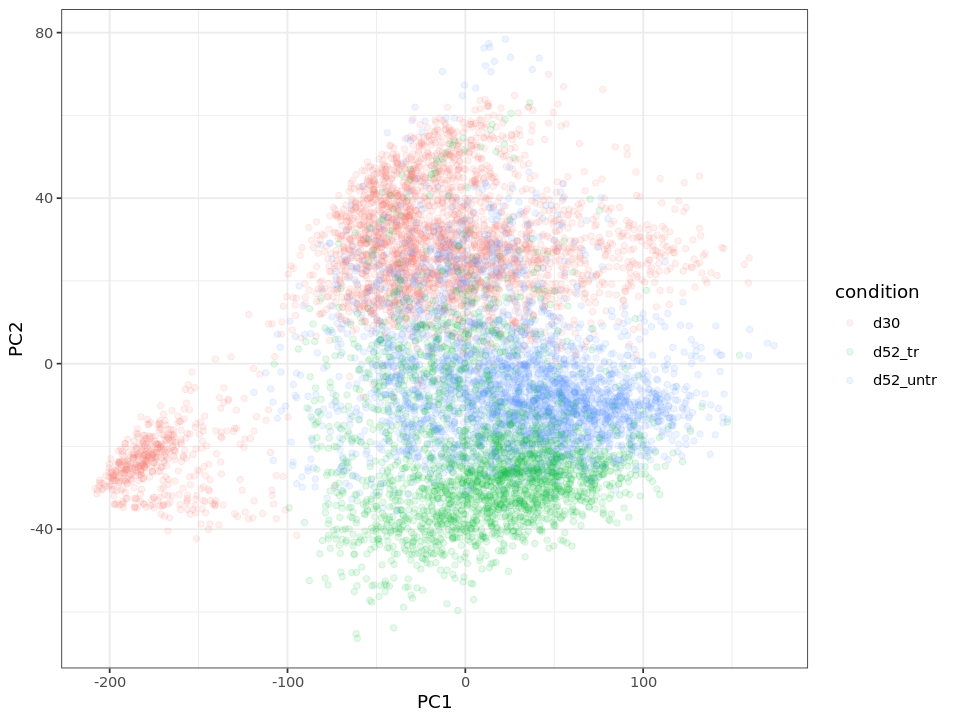

In [52]:
options(repr.plot.width = 8, repr.plot.height = 6)
p = ggplot(df_pca, aes(x = PC1, y = PC2, col = condition)) + geom_point(alpha = 0.1) + theme_bw()
p

In [58]:
umap = umap(pca[,1:20])
# umap = umap(pca[,1:50])
df_umap = data.frame(umap$layout)
colnames(df_umap) = c("UMAP1","UMAP2")
head(df_umap,2)

,UMAP1,UMAP2
iudw_1..cluster0,5.465958,-7.654659
iudw_1..cluster1,3.492185,-5.517851


In [59]:
df_umap$condition = sce$Condition
df_umap$donor = sce$donor
df_umap$pseudocell = sce$pseudocell

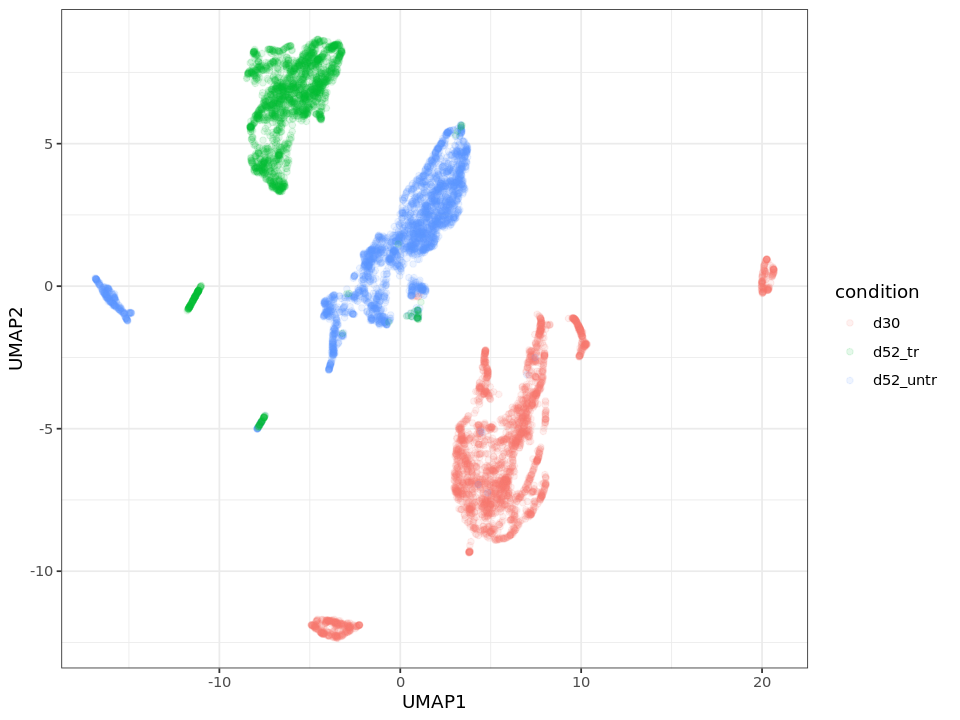

In [60]:
options(repr.plot.width = 8, repr.plot.height = 6)
p = ggplot(df_umap, aes(x = UMAP1, y = UMAP2, col = condition)) + geom_point(alpha = 0.1) + theme_bw()
p

In [61]:
length(unique(sce$donor))

[1] 192

In [62]:
cells_sel1 = rownames(df_umap[df_umap$UMAP2<-10,])
cells_sel2 = rownames(df_umap[df_umap$UMAP1>15,])
cells_sel = c(cells_sel1,cells_sel2)

In [63]:
sce_sel = sce[,cells_sel]

ERROR: Error in SummarizedExperiment:::.SummarizedExperiment.charbound(subset, : index out of bounds: iudw_1..cluster9 boqx_2..cluster0 ... oesx_3..cluster7 oesx_3..cluster9


In [16]:
table(sce_sel$donor)


aehn_22 aipt_33  bima_1  eorc_2  iill_3  iudw_1  iuqb_1  jufd_3  kute_5  mioj_1 
     11      22      19      23      18       1      23      12      15      27 
 peoj_1  ruql_3  uaqe_1  zexw_3  zuuy_4 
     11      16      12      21      11 

In [64]:
sce_sel1 = sce[,!(colnames(sce) %in% cells_sel)]

In [65]:
length(unique(sce_sel1$donor))

[1] 192

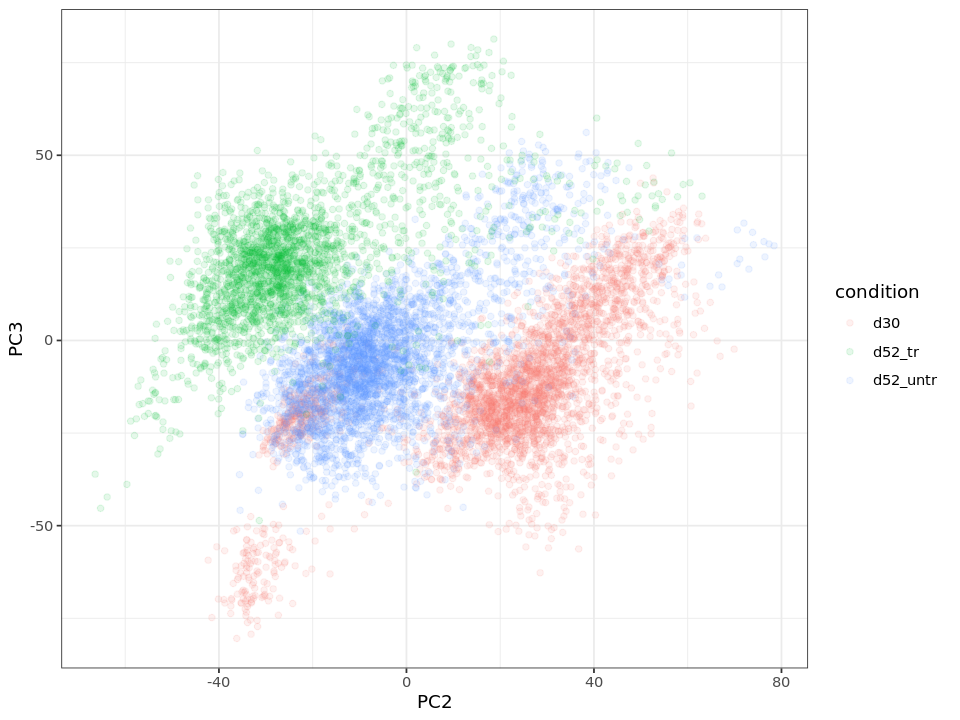

In [67]:
pca = prcomp(t(counts(sce_sel1)))$x
df_pca = data.frame(pca)
df_pca$condition = sce_sel1$Condition
p = ggplot(df_pca, aes(x = PC2, y = PC3, col = condition)) + geom_point(alpha = 0.1) + theme_bw()
p

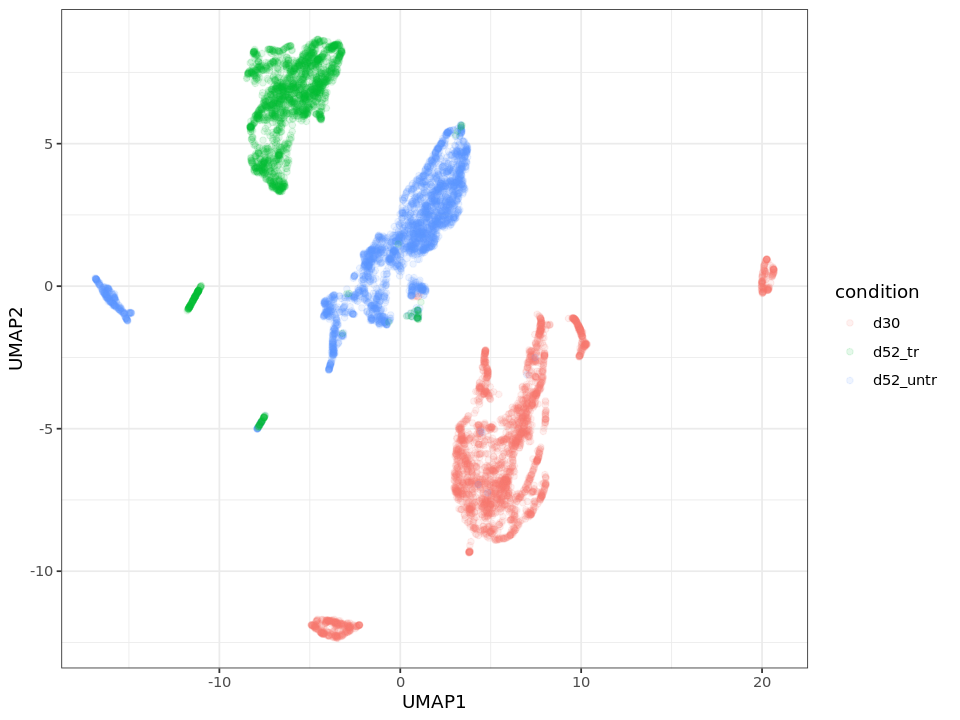

In [69]:
# umap = umap(pca[,1:20])
df_umap = data.frame(umap$layout)
colnames(df_umap) = c("UMAP1","UMAP2")
df_umap$condition = sce_sel1$Condition
df_umap$donor = sce_sel1$donor
df_umap$pseudocell = sce_sel1$pseudocell
options(repr.plot.width = 8, repr.plot.height = 6)
p = ggplot(df_umap, aes(x = UMAP1, y = UMAP2, col = condition)) + geom_point(alpha = 0.1) + theme_bw()
p

In [22]:
write.csv(df_umap, "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/PCA/umap_PC15.csv")

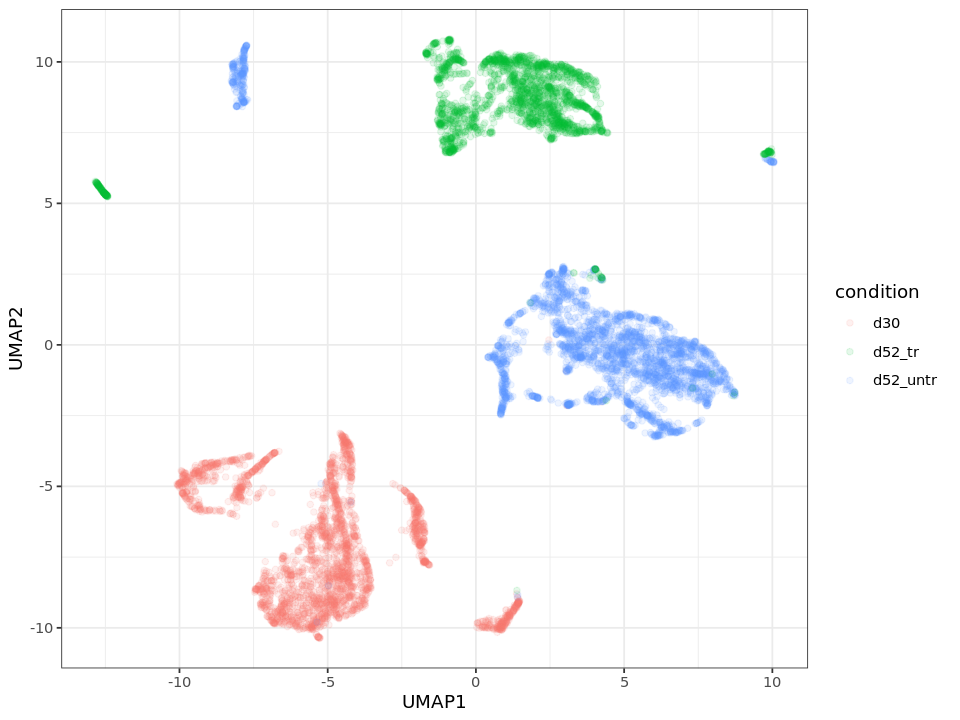

In [85]:
options(repr.plot.width = 8, repr.plot.height = 6)
p = ggplot(df_umap, aes(x = UMAP1, y = UMAP2, col = condition)) + geom_point(alpha = 0.1) + theme_bw()
# p = p + scale_color_canva(palette = "Pool party") 
p

In [88]:
donors = unique(sce$donor)
head(donors)

[1] "iudw_1" "paim_1" "liqa_1" "suop_5" "eiwy_1" "podx_1"

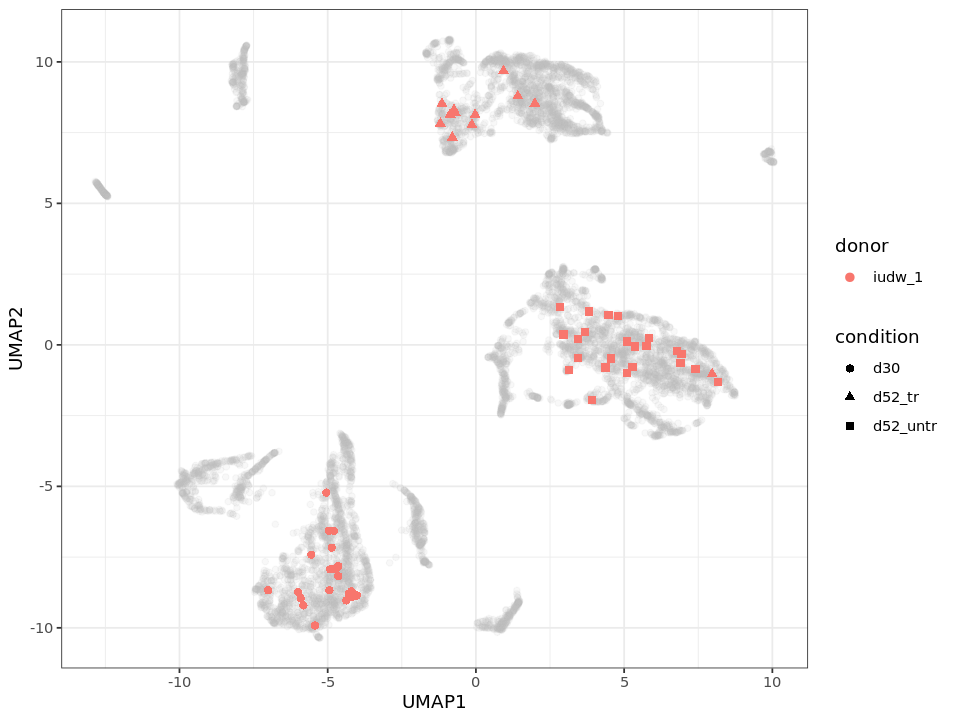

In [103]:
options(repr.plot.width = 8, repr.plot.height = 6)
p = ggplot(df_umap, aes(x = UMAP1, y = UMAP2)) + geom_point(alpha = 0.1, col = "grey") + theme_bw()
p = p + geom_point(aes(x = UMAP1, y = UMAP2, colour = donor, shape = condition),size=2, 
                   data = df_umap[df_umap$donor %in% donors[1],])
p